# Recipe  Review and User Feedback Dataset

https://doi.org/10.24432/C5FG95
## Methodology Framework: CRISP-DM & AWS Well-Architected ML
### Framework Synergies
1. **Data Quality & Reliability**:
   - CRISP-DM: Data understanding and preparation
   - AWS: Reliability pillar for robust implementation

2. **Model Development**:
   - CRISP-DM: Modeling and evaluation phases
   - AWS: Performance efficiency and operational excellence

3. **Business Impact**:
   - CRISP-DM: Business understanding and deployment.
   - AWS: Cost optimization and security considerations.

---
### Sections:

 1. [Bussiness Understanding](#1bussiness-understanding).
 2. [Data Understanding](#2data-understanding). 
 3. [Data Preparation](#3data-preparation).
 4. [Modelling](#4-modeling). 
 5. [Evaluation](#5-evaluation). 
 6. Deployment.
---

### 1: Business Understanding
Business Objective:
- Analyse sentiment from recipe reviews and ratings.
- Extract insights about user satisfaction and feedback patterns based on model.
- Build predictive model for sentiment classification to track user satisfaction.

### 2.Data Understanding and Preprocessing.

#### 2.1 Dependecies.

In [60]:
# Standard Libraries
import os
import pickle
import time
from typing import (
    Dict, 
    List,
    Tuple
)

# Data Manipulation
import numpy as np
import pandas as pd
from collections import Counter
from scipy import sparse
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.calibration import label_binarize


# Natural Language Processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer


# NLTK Downloads
nltk.download(['punkt', 'stopwords', 'vader_lexicon'])

# Machine Learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split


# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, 
    LSTM, 
    Dropout, 
    Bidirectional, 
    BatchNormalization, 
    Reshape
)
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint, 
    ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization Settings
sns.set_theme(style="whitegrid", palette="dark")

# Optional: Set random seeds for reproducibility
np.random.seed(98)
tf.random.set_seed(98)

[nltk_data] Downloading package punkt to /home/geo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/geo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/geo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### 2.2 Define Paths.

In [2]:
DATA_PATH = "../data/raw/Recipe Reviews and User Feedback Dataset.csv"
PROCESSED_PATH = "../data/processed/Task_3_processed/"
FIGURE_PATH = "../reports/figures/Task_3/"
EVAL_PATH = "../reports/model_evaluations/Task_3/"
MODEL_DIR = "../models/Task_3/"


#### 2.3 Load the Dataset.

In [3]:
df = pd.read_csv(DATA_PATH)

#### 2.4 Display Basic Information.

In [4]:
# Display basic dataset information
print("Dataset Shape:", df.shape)
print("\nFeature Information:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nFirst few rows:")
display(df.head())
print("\nLast few rows")
display(df.tail())

Dataset Shape: (18182, 15)

Feature Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18182 entries, 0 to 18181
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       18182 non-null  int64 
 1   recipe_number    18182 non-null  int64 
 2   recipe_code      18182 non-null  int64 
 3   recipe_name      18182 non-null  object
 4   comment_id       18182 non-null  object
 5   user_id          18182 non-null  object
 6   user_name        18182 non-null  object
 7   user_reputation  18182 non-null  int64 
 8   created_at       18182 non-null  int64 
 9   reply_count      18182 non-null  int64 
 10  thumbs_up        18182 non-null  int64 
 11  thumbs_down      18182 non-null  int64 
 12  stars            18182 non-null  int64 
 13  best_score       18182 non-null  int64 
 14  text             18180 non-null  object
dtypes: int64(10), object(5)
memory usage: 2.1+ MB

Missing Values:
Unnamed: 

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...



Last few rows


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
18177,114,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_331352,u_1oKblS4ULpTAACUTILo0QlO5mrN,WhittierCA,1,1622717977,0,0,0,5,100,This Strawberry Cake has been a family favorit...
18178,115,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_204836,u_1oKY7CKLaFQpI3cBCVaxHXAEGbt,susieswan,1,1613036720,0,0,0,5,100,<p>I received endless compliments on this cake...
18179,116,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_301178,u_1oKXBAuHbMDi9nnriVAbJoPqpeQ,blajr,1,1622717844,0,0,0,5,100,This cake was delicious and so moist! I didn&#...
18180,117,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_180512,u_1oKVbnueXfnlmYWuYH8xJ0mFxNQ,cafritz,1,1622717233,0,0,0,5,100,I just made this too. It is wonderful. As fo...
18181,118,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_262637,u_1oKW6W12cOLxiMzjA7j8nTqwFWG,nopalito,1,1622717625,0,1,0,5,193,"OMG, you must make this cake. I made it for my..."


#### 2.5 Exploratoy Data Anlysis

In [5]:
print("Statistical Summary:")
print(df.describe().T)

# Display value counts for ratings
print("\nRating Distribution:")
print(df['stars'].value_counts().sort_index())

Statistical Summary:
                   count          mean  ...           75%           max
Unnamed: 0       18182.0  1.214653e+02  ...  1.500000e+02  7.240000e+02
recipe_number    18182.0  3.868936e+01  ...  6.400000e+01  1.000000e+02
recipe_code      18182.0  2.177367e+04  ...  3.312100e+04  1.917750e+05
user_reputation  18182.0  2.159608e+00  ...  1.000000e+00  5.200000e+02
created_at       18182.0  1.623710e+09  ...  1.622718e+09  1.665756e+09
reply_count      18182.0  1.462985e-02  ...  0.000000e+00  3.000000e+00
thumbs_up        18182.0  1.089264e+00  ...  0.000000e+00  1.060000e+02
thumbs_down      18182.0  5.493345e-01  ...  0.000000e+00  1.260000e+02
stars            18182.0  4.288802e+00  ...  5.000000e+00  5.000000e+00
best_score       18182.0  1.531621e+02  ...  1.000000e+02  9.460000e+02

[10 rows x 8 columns]

Rating Distribution:
stars
0     1696
1      280
2      232
3      490
4     1655
5    13829
Name: count, dtype: int64


##### 2.5.1 Star Rating Distribution

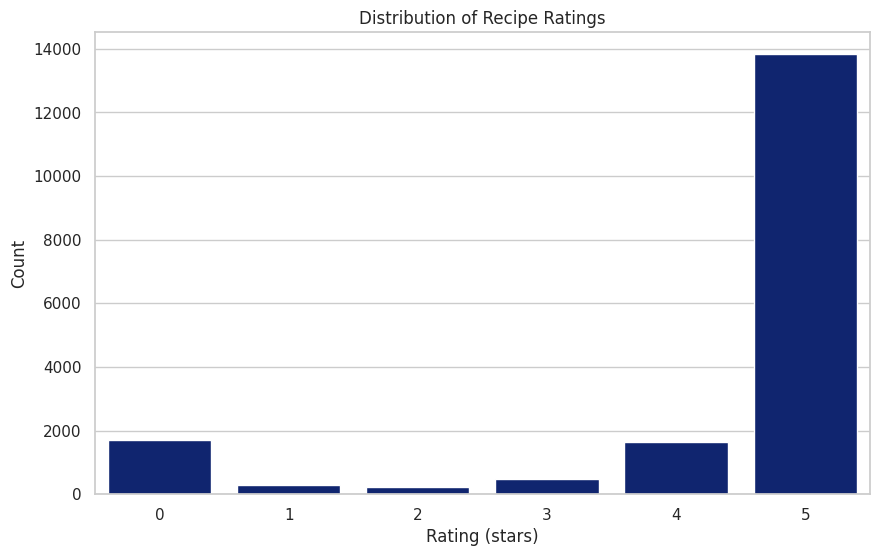

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='stars')
plt.title('Distribution of Recipe Ratings')
plt.xlabel('Rating (stars)')
plt.ylabel('Count')
plt.savefig(f'{FIGURE_PATH}/rating_distribution.png')
plt.show()
plt.close()

##### 2.5.2 Text Analysis

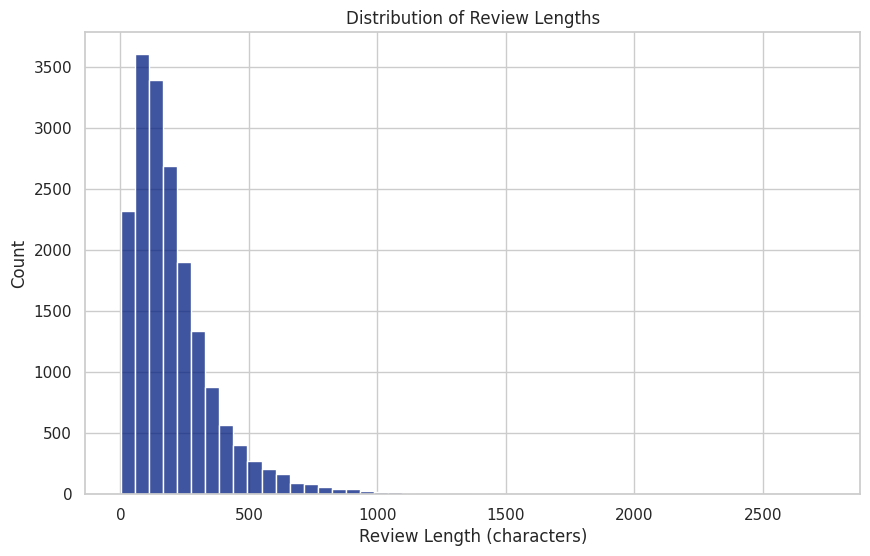

In [7]:
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.savefig(f'{FIGURE_PATH}/text_length_distribution.png')
plt.show()
plt.close()

In [8]:
# Print text length statistics
print("\nReview Length Statistics:")
print(df['text_length'].describe())


Review Length Statistics:
count    18180.000000
mean       203.909681
std        172.455624
min          1.000000
25%         90.000000
50%        161.000000
75%        266.000000
max       2742.000000
Name: text_length, dtype: float64


##### 2.5.3 User Engagement

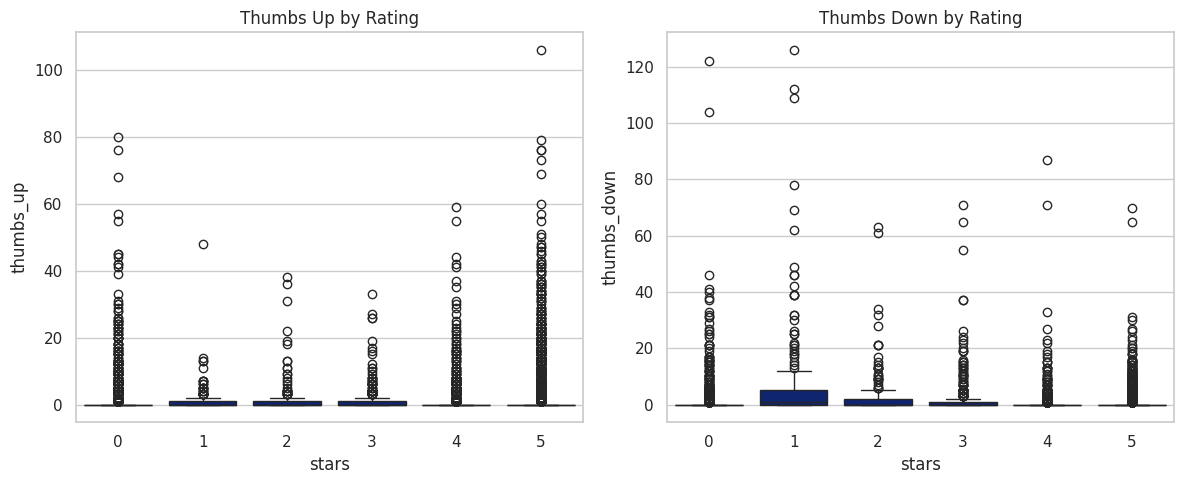

In [9]:
plt.figure(figsize=(12, 5))

# Thumbs up/down by rating
plt.subplot(121)
sns.boxplot(data=df, x='stars', y='thumbs_up')
plt.title('Thumbs Up by Rating')

plt.subplot(122)
sns.boxplot(data=df, x='stars', y='thumbs_down')
plt.title('Thumbs Down by Rating')

plt.tight_layout()
plt.savefig(f'{FIGURE_PATH}/engagement_by_rating.png')
plt.show()
plt.close()

##### 2.5.4 Correlation Analysis

In [ ]:
def analyse_correlations(df: pd.DataFrame) -> None:
    """
    Analyse correlations between numerical features and target variable.
    """
    # Select numerical columns including engagement metrics
    numerical_cols = [
        'stars',
        'thumbs_up',
        'thumbs_down',
        'reply_count',
        'user_reputation',
        'best_score',
        'text_length'
    ]
    
    # Create correlation matrix
    correlation_matrix = df[numerical_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='Blues',
        fmt='.2f',
        square=True,
        center=0,
        vmin=-1,
        vmax=1,
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}/correlation_matrix.png")
    plt.show()
    plt.close
    
    # Print correlations with star rating
    print("\nCorrelations with Star Rating:")
    correlations = correlation_matrix['stars'].sort_values(ascending=False)
    for feature, corr in correlations.items():
        if feature != 'stars':
            print(f"{feature}: {corr:.3f}")

    # Additional analysis of engagement metrics
    print("\nEngagement Metrics Statistics by Rating:")
    engagement_metrics = ['thumbs_up', 'thumbs_down', 'reply_count']
    
    for metric in engagement_metrics:
        print(f"\n{metric.replace('_', ' ').title()} by Star Rating:")
        print(df.groupby('stars')[metric].describe()[['mean', 'std', 'max']])

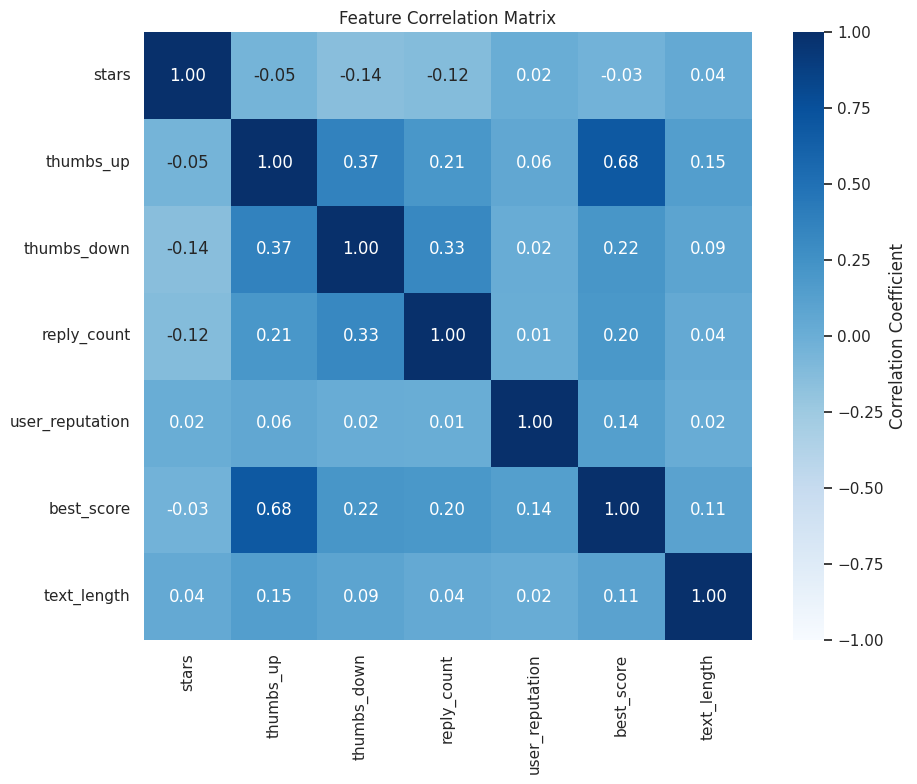


Correlations with Star Rating:
text_length: 0.043
user_reputation: 0.016
best_score: -0.034
thumbs_up: -0.051
reply_count: -0.120
thumbs_down: -0.143

Engagement Metrics Statistics by Rating:

Thumbs Up by Star Rating:
           mean       std    max
stars                           
0      1.771816  6.095731   80.0
1      0.992857  3.447500   48.0
2      1.521552  4.872350   38.0
3      1.138776  3.361201   33.0
4      1.073716  4.177660   59.0
5      1.000362  3.931591  106.0

Thumbs Down by Star Rating:
           mean        std    max
stars                            
0      1.102005   5.474282  122.0
1      6.082143  15.762929  126.0
2      2.758621   7.531315   63.0
3      1.981633   6.572365   71.0
4      0.590937   3.455020   87.0
5      0.276737   1.535095   70.0

Reply Count by Star Rating:
           mean       std  max
stars                         
0      0.051887  0.269856  3.0
1      0.067857  0.265796  2.0
2      0.068966  0.314832  3.0
3      0.057143  0.265231  2.0


In [ ]:
# Analyze correlations
analyse_correlations(df)

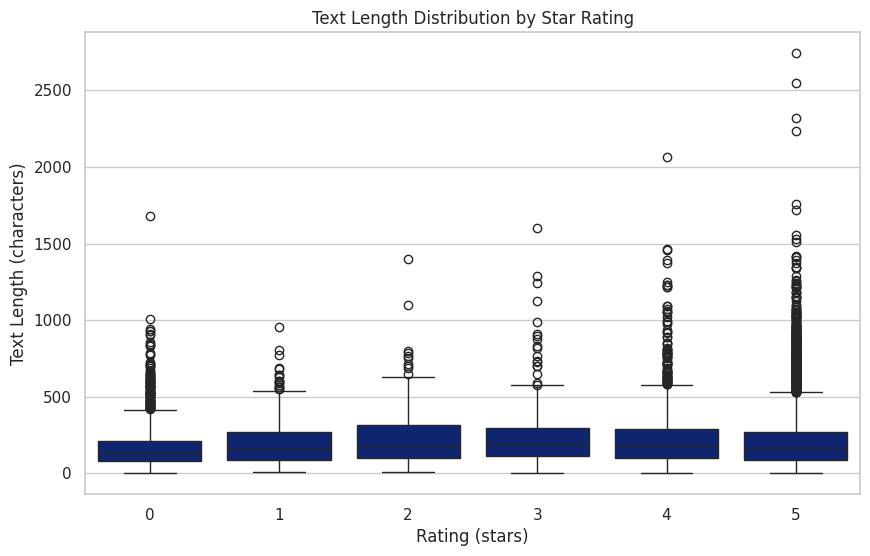

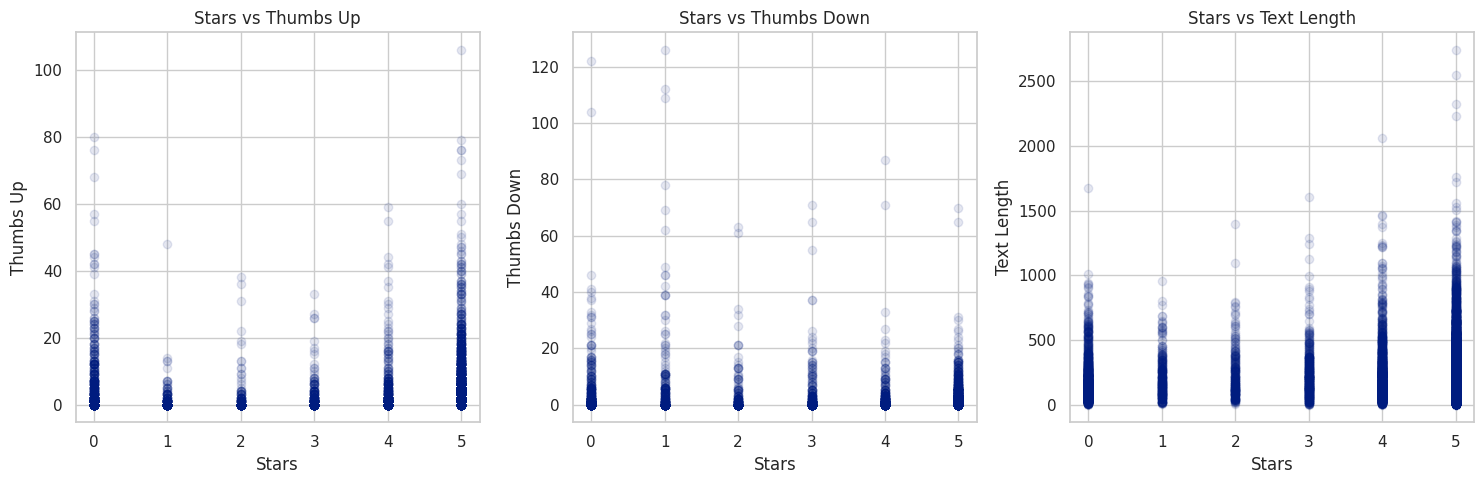

In [ ]:
# Visualise relationship between stars and text length
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='stars', y='text_length')
plt.title('Text Length Distribution by Star Rating')
plt.xlabel('Rating (stars)')
plt.ylabel('Text Length (characters)')
plt.savefig(f"{FIGURE_PATH}/text_length_by_rating.png")
plt.show()
plt.close()

# Create scatter plots for key relationships
plt.figure(figsize=(15, 5))

# Stars vs Thumbs Up
plt.subplot(131)
plt.scatter(df['stars'], df['thumbs_up'], alpha=0.1)
plt.title('Stars vs Thumbs Up')
plt.xlabel('Stars')
plt.ylabel('Thumbs Up')

# Stars vs Thumbs Down
plt.subplot(132)
plt.scatter(df['stars'], df['thumbs_down'], alpha=0.1)
plt.title('Stars vs Thumbs Down')
plt.xlabel('Stars')
plt.ylabel('Thumbs Down')

# Stars vs Text Length
plt.subplot(133)
plt.scatter(df['stars'], df['text_length'], alpha=0.1)
plt.title('Stars vs Text Length')
plt.xlabel('Stars')
plt.ylabel('Text Length')

plt.tight_layout()
plt.savefig(f"{FIGURE_PATH}/feature_relationships.png")
plt.show()
plt.close()


##### 2.5.5 Word Cloud.

Generating word clouds for reviews...


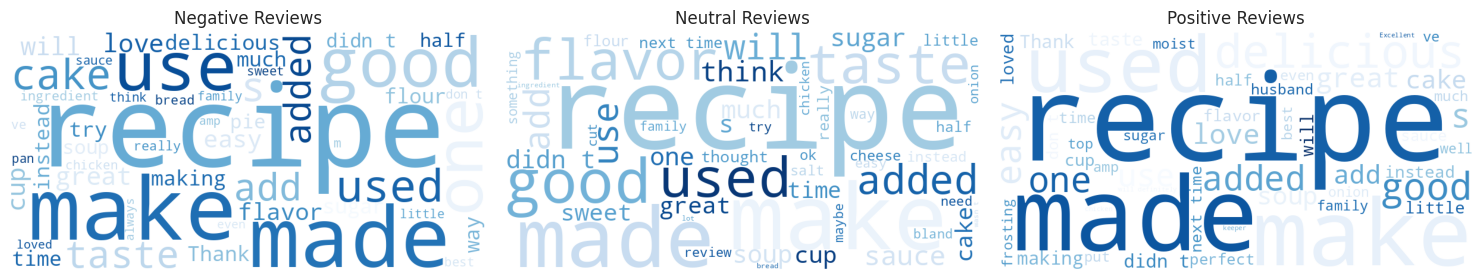

In [ ]:
def wordcloud(df: pd.DataFrame) -> None:
    """
    Create simple word clouds for positive, neutral and negative reviews.
    """
    # Create figure with subplots
    plt.figure(figsize=(15, 5))
    
    # Prepare data for each sentiment
    sentiment_data = {
        'Negative Reviews': df[df['stars'] <= 2]['text'],
        'Neutral Reviews': df[df['stars'] == 3]['text'],
        'Positive Reviews': df[df['stars'] >= 4]['text']
    }
    
    # Create word clouds
    for idx, (title, texts) in enumerate(sentiment_data.items(), 1):
        # Combine all texts
        text = ' '.join(texts.astype(str))
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            max_words=50,
            colormap='Blues'
        ).generate(text)
        
        # Add subplot
        plt.subplot(1, 3, idx)
        plt.imshow(wordcloud)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}/review_wordclouds.png")
    plt.show()
    plt.close()

# Generate word clouds
wordcloud(df)

##### 2.5.6 Word Frequency.

In [ ]:
def analyse_word_frequencies(df: pd.DataFrame, top_n: int = 20) -> None:
    """
    Analyse and visualise word frequencies for different sentiment categories.
    """
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Add custom stopwords for recipe reviews
    recipe_stopwords = {
    # Basic recipe terms
    'recipe', 'recipes', 'cook', 'cooking', 
    
    # Common actions
    'made', 'make', 'making',
    
    # Generic food terms
    'food', 'dish', 'meal', 'ingredients',
    
    # Kitchen/time related
    'kitchen', 'minutes', 'hour', 'hours', 'time',
    
    # Generic descriptors
    'like', 'just', 'one', 'will', 'used', 'use',
    
    # Common positive words (too generic)
    'good', 'great', 'better', 'best', 'really', 
    
    # Quantity words
    'much', 'way'
}
    stop_words.update(recipe_stopwords)
    
    def get_word_freq(texts):
        # Combine all texts and convert to lowercase
        text = ' '.join(texts.astype(str)).lower()
        
        # Tokenize
        words = word_tokenize(text)
        
        # Remove stopwords, special characters, and short words
        words = [word for word in words 
                if word.isalnum() 
                and word not in stop_words 
                and len(word) > 2]
        
        return Counter(words)
    
    # Get word frequencies for each sentiment
    neg_freq = get_word_freq(df[df['stars'] <= 2]['text'])
    neu_freq = get_word_freq(df[df['stars'] == 3]['text'])
    pos_freq = get_word_freq(df[df['stars'] >= 4]['text'])
    
    # Get top words overall
    all_words = pd.DataFrame([
        {'word': word, 
         'negative': neg_freq[word],
         'neutral': neu_freq[word],
         'positive': pos_freq[word]}
        for word in set().union(*[neg_freq, neu_freq, pos_freq])
    ])
    
    # Calculate totals and sort
    all_words['total'] = all_words['negative'] + all_words['neutral'] + all_words['positive']
    all_words = all_words.sort_values('total', ascending=False)
    
    # Plot top most words
    top_words = all_words.head(top_n)
    
    # Create stacked bar chart
    plt.figure(figsize=(15, 8))
    bar_width = 0.7
    
    plt.bar(top_words['word'], top_words['negative'], 
            label='Negative Reviews', color='lightcoral', width=bar_width)
    plt.bar(top_words['word'], top_words['neutral'], bottom=top_words['negative'],
            label='Neutral Reviews', color='lightgray', width=bar_width)
    plt.bar(top_words['word'], top_words['positive'], 
            bottom=top_words['negative'] + top_words['neutral'],
            label='Positive Reviews', color='lightblue', width=bar_width)
    
    plt.title('Most Frequent Words by Sentiment Category')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}/word_frequencies.png")
    plt.show()
    plt.close()
    
    # Print frequency table
    print("\nTop 20 Most Frequent Words and their Distribution:")
    freq_table = top_words.copy()
    for col in ['negative', 'neutral', 'positive']:
        freq_table[f'{col}_pct'] = freq_table[col] / freq_table['total'] * 100
    
    print(freq_table[[
        'word', 'total',
        'negative_pct', 'neutral_pct', 'positive_pct'
    ]].round(2).to_string())
    
    return freq_table



Analyzing word frequencies...


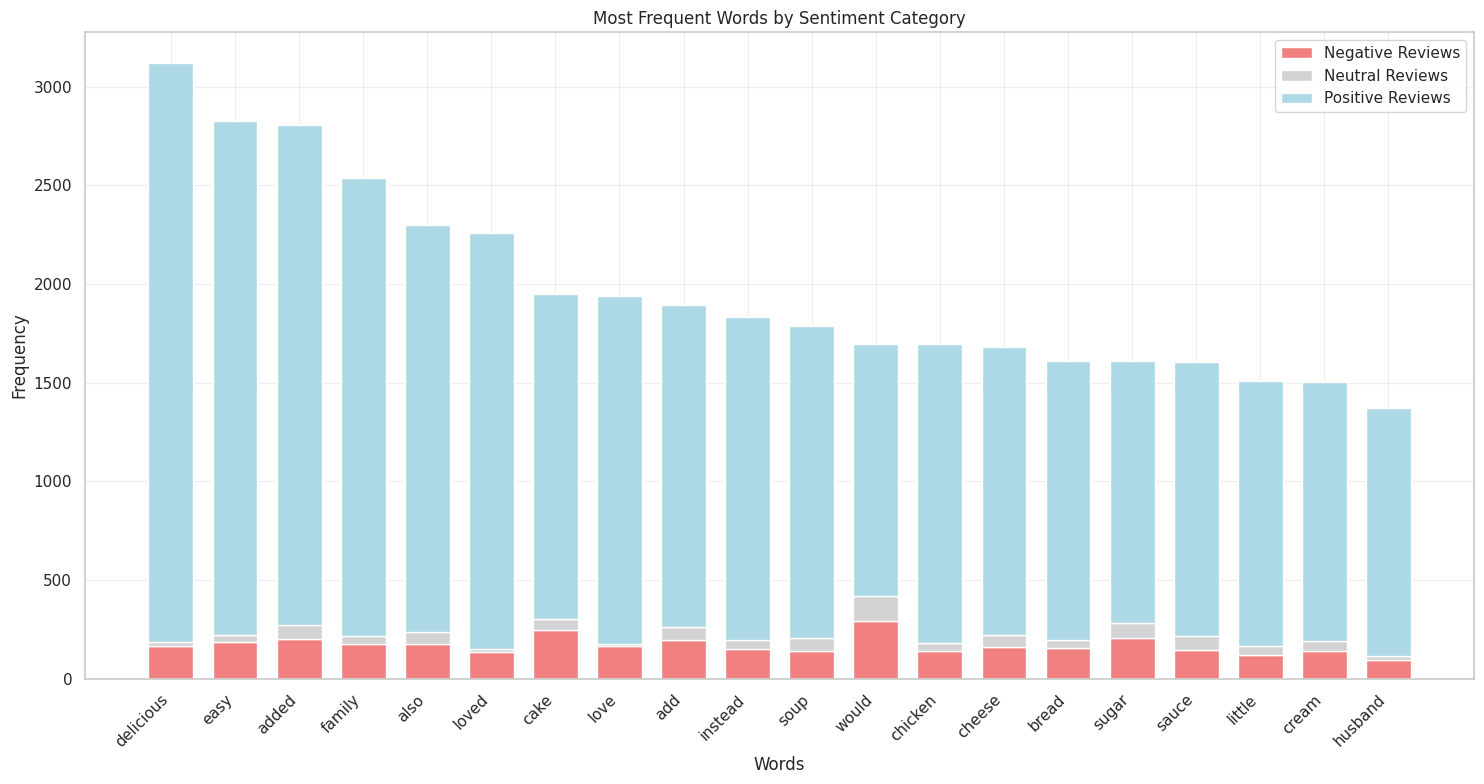


Top 20 Most Frequent Words and their Distribution:
            word  total  negative_pct  neutral_pct  positive_pct
4883   delicious   3119          5.42         0.55         94.04
8343        easy   2824          6.62         1.20         92.17
3211       added   2807          7.20         2.53         90.27
10886     family   2538          7.01         1.58         91.41
9045        also   2298          7.79         2.57         89.64
9777       loved   2257          5.98         0.80         93.22
962         cake   1950         12.82         2.67         84.51
3296        love   1939          8.51         0.72         90.77
1423         add   1892         10.36         3.49         86.15
4642     instead   1834          8.40         2.24         89.37
6045        soup   1787          7.83         3.69         88.47
582        would   1697         17.21         7.54         75.25
49       chicken   1694          8.26         2.42         89.32
10933     cheese   1680          9.52 

In [ ]:
# Analyse word frequencies
print("Analyzing word frequencies...")
freq_table = analyse_word_frequencies(df)
# Save frequency analysis
freq_table.to_csv(f"{PROCESSED_PATH}/word_frequencies.csv", index=False)

### 3. Data Preparation.

#### 3.1 Data Cleaning and Preparation.
Multi step cleaning: 

In [16]:
def clean_and_prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and prepare data for modeling.
    Based on insights from word frequency analysis.
    """
    # Make a copy to avoid modifying original data
    df_cleaned = df.copy()
    
    # 1. Remove 0 ratings and empty reviews due to low amount of data ~1k reviews
    print("Removing invalid entries...")
    df_cleaned = df_cleaned[df_cleaned['stars'] > 0]
    df_cleaned = df_cleaned.dropna(subset=['text'])
    
    # 2. Convert ratings to sentiment categories (negative, neutral, positive)
    print("Creating sentiment labels...")
    df_cleaned['sentiment'] = df_cleaned['stars'].apply(
        lambda x: 'negative' if x <= 2 
        else 'neutral' if x == 3 
        else 'positive'
    )
    
    # 3. Clean text content
    print("Cleaning text content >>>")
    df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text)
    
    # 4. Add VADER sentiment scores: Vader is a rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
    print("Adding VADER sentiment scores >>>")
    sid = SentimentIntensityAnalyzer()
    df_cleaned['vader_scores'] = df_cleaned['cleaned_text'].apply(
        lambda x: sid.polarity_scores(x))
    
    # Extract VADER features
    df_cleaned['vader_compound'] = df_cleaned['vader_scores'].apply(lambda x: x['compound'])
    df_cleaned['vader_pos'] = df_cleaned['vader_scores'].apply(lambda x: x['pos'])
    df_cleaned['vader_neg'] = df_cleaned['vader_scores'].apply(lambda x: x['neg'])
    df_cleaned = df_cleaned.drop('vader_scores', axis=1)
    
    # 5. Create text length features
    print("Creating text features >>>")
    df_cleaned['text_length'] = df_cleaned['cleaned_text'].str.len()
    df_cleaned['word_count'] = df_cleaned['cleaned_text'].str.split().str.len()
    
    # 6. Create binary indicators for key terms
    print("Creating keyword indicators >>>")
    key_positive_words = ['delicious', 'easy', 'loved', 'family', 'perfect'] # from previous analysis 
    key_negative_words = ['would', 'instead', 'but', 'however'] # from previous analysis
    
    for word in key_positive_words:
        df_cleaned[f'has_{word}'] = df_cleaned['cleaned_text'].str.contains(
            r'\b' + word + r'\b', case=False).astype(int)
    
    for word in key_negative_words:
        df_cleaned[f'has_{word}'] = df_cleaned['cleaned_text'].str.contains(
            r'\b' + word + r'\b', case=False).astype(int)
    
    return df_cleaned

#### 3.2 Tex Cleaning.

In [17]:
def clean_text(text: str) -> str:
    """
    Clean text while preserving meaningful terms.
    """
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove special characters but keep meaningful punctuation
    text = re.sub(r'[^a-z\s.,!?]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

#### 3.3 Execute Data Preparation.

In [18]:
# Execute data preparation
print("Starting data preparation >>>")
df_prepared = clean_and_prepare_data(df)

# Display results
print("\nShape of prepared dataset:", df_prepared.shape)
print("\nSentiment distribution:")
print(df_prepared['sentiment'].value_counts())

# Save prepared dataset
print("\nSaving prepared dataset >>>")
save_path = f"{PROCESSED_PATH}/prepared_data.csv"
df_prepared.to_csv(save_path, index=False)
print(f"Dataset saved to: {save_path}")

# Display sample of prepared data
print("\nSample of prepared data:")
sample_cols = ['sentiment', 'cleaned_text', 'vader_compound', 'text_length'] + \
             [col for col in df_prepared.columns if col.startswith('has_')]
print(df_prepared[sample_cols].head())

Starting data preparation >>>
Removing invalid entries...
Creating sentiment labels...
Cleaning text content >>>
Adding VADER sentiment scores >>>
Creating text features >>>
Creating keyword indicators >>>

Shape of prepared dataset: (16484, 31)

Sentiment distribution:
sentiment
positive    15482
negative      512
neutral       490
Name: count, dtype: int64

Saving prepared dataset >>>
Dataset saved to: ../data/processed/Task_3_processed//prepared_data.csv

Sample of prepared data:
  sentiment  ... has_however
0  positive  ...           0
1  positive  ...           0
2  positive  ...           0
5  positive  ...           0
6  positive  ...           0

[5 rows x 13 columns]


Data Process Changes: *PREVIOUS* to *NEW*

In [ ]:
def validate_preprocessing(df_original: pd.DataFrame, df_prepared: pd.DataFrame) -> None:
    """
    Validate preprocessing steps and display key metrics.
    """
    print("Preprocessing Validation Report")
    print("=" * 50)
    
    # 1. Data Size Changes
    print("\n1. Data Size Analysis:")
    print(f"Original rows: {len(df_original)}")
    print(f"Prepared rows: {len(df_prepared)}")
    print(f"Rows removed: {len(df_original) - len(df_prepared)}")
    
    # 2. Sentiment Distribution
    print("\n2. Sentiment Distribution:")
    sentiment_dist = df_prepared['sentiment'].value_counts()
    for sentiment, count in sentiment_dist.items():
        percentage = (count / len(df_prepared)) * 100
        print(f"{sentiment}: {count} ({percentage:.2f}%)")
    
    # 3. VADER Sentiment Analysis
    print("\n3. VADER Sentiment Correlation with Ratings:")
    vader_corr = df_prepared['vader_compound'].corr(df_prepared['stars'])
    print(f"Correlation between VADER compound score and star rating: {vader_corr:.3f}")
    
    # 4. Key Term Analysis
    print("\n4. Key Term Frequencies by Sentiment:")
    key_term_cols = [col for col in df_prepared.columns if col.startswith('has_')]
    
    # Calculate frequencies
    term_stats = []
    for col in key_term_cols:
        term = col.replace('has_', '')
        stats = df_prepared.groupby('sentiment')[col].mean()
        term_stats.append({
            'term': term,
            'negative': stats['negative'],
            'neutral': stats['neutral'],
            'positive': stats['positive']
        })
    
    term_df = pd.DataFrame(term_stats)
    print("\nKey term frequencies by sentiment:")
    print(term_df.round(3))
    
    # 5. Text Length Analysis
    print("\n5. Text Length Analysis by Sentiment:")
    length_stats = df_prepared.groupby('sentiment')['text_length'].agg(['mean', 'std', 'min', 'max'])
    print(length_stats.round(2))
    
    # Visualise preprocessing results
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Sentiment Distribution
    plt.subplot(131)
    sns.countplot(data=df_prepared, x='sentiment', palette='Blues')
    plt.title('Sentiment Distribution')
    plt.xticks(rotation=45)
    
    # Plot 2: VADER Compound Scores by Sentiment
    plt.subplot(132)
    sns.boxplot(data=df_prepared, x='sentiment', y='vader_compound', palette='Blues')
    plt.title('VADER Scores by Sentiment')
    plt.xticks(rotation=45)
    
    # Plot 3: Text Length Distribution by Sentiment
    plt.subplot(133)
    sns.boxplot(data=df_prepared, x='sentiment', y='text_length', palette='Blues')
    plt.title('Text Length by Sentiment')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}/preprocessing_validation.png")
    plt.show()

Validating preprocessing results...
Preprocessing Validation Report

1. Data Size Analysis:
Original rows: 18182
Prepared rows: 16484
Rows removed: 1698

2. Sentiment Distribution:
positive: 15482 (93.92%)
negative: 512 (3.11%)
neutral: 490 (2.97%)

3. VADER Sentiment Correlation with Ratings:
Correlation between VADER compound score and star rating: 0.364

4. Key Term Frequencies by Sentiment:

Key term frequencies by sentiment:
        term  negative  neutral  positive
0  delicious     0.025    0.035     0.184
1       easy     0.023    0.065     0.164
2      loved     0.010    0.033     0.130
3     family     0.045    0.080     0.142
4    perfect     0.012    0.010     0.058
5      would     0.201    0.212     0.073
6    instead     0.039    0.071     0.094
7        but     0.352    0.463     0.189
8    however     0.018    0.039     0.013

5. Text Length Analysis by Sentiment:
             mean     std  min   max
sentiment                           
negative   212.31  173.21    8  1

/tmp/ipykernel_233729/1442444007.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_prepared, x='sentiment', palette='Blues')
/tmp/ipykernel_233729/1442444007.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_prepared, x='sentiment', y='vader_compound', palette='Blues')
/tmp/ipykernel_233729/1442444007.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_prepared, x='sentiment', y='text_length', palette='Blues')


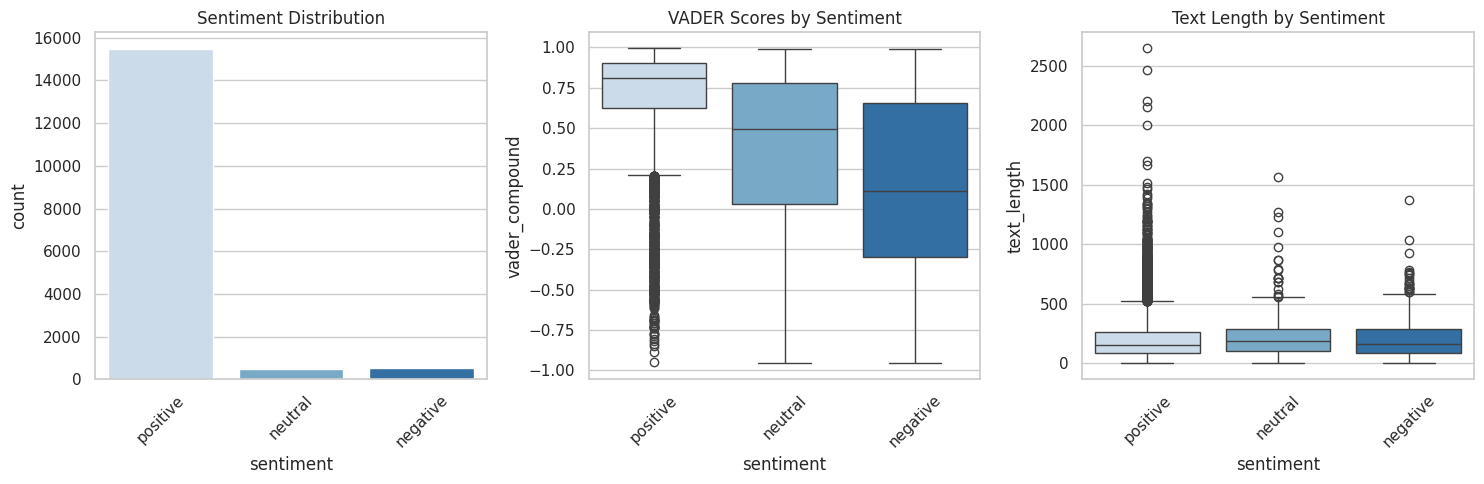

In [ ]:
validate_preprocessing(df, df_prepared)

#### 3.4 Feature Engenieering.

In [ ]:
def prepare_final_dataset(df: pd.DataFrame) -> Tuple:
    """
    Prepare final dataset for sentiment analysis modeling.
    
    """
    # Process text using TF-IDF
    tfidf = TfidfVectorizer(
        max_features=5000,
        min_df=5,
        max_df=0.95,
        ngram_range=(1, 2)
    )
    
    # Fit and transform the text data
    X = tfidf.fit_transform(df['cleaned_text'])
    
    # Encode sentiment labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['sentiment'])
    
    # Split dataset
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=98, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=98, stratify=y_temp
    )
    
    # Balance training data
    smote = SMOTE(random_state=98)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    # Calculate class weights
    class_counts = np.bincount(y_train)
    total = len(y_train)
    class_weights = {i: total / (len(class_counts) * count) 
                    for i, count in enumerate(class_counts)}
    
    print("\nOriginal class distribution:")
    print(pd.Series(y_train).value_counts().sort_index())
    print("\nBalanced class distribution:")
    print(pd.Series(y_train_balanced).value_counts().sort_index())
    
    return (X_train_balanced, X_val, X_test,
            y_train_balanced, y_val, y_test,
            class_weights, label_encoder, tfidf)

#### 3.5 Data Preparation Execution.

In [27]:
# Execute data preparation
print("Preparing final dataset...")
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 class_weights, label_encoder, tfidf) = prepare_final_dataset(df_prepared)

Preparing final dataset...

Original class distribution:
0      358
1      343
2    10837
Name: count, dtype: int64

Balanced class distribution:
0    10837
1    10837
2    10837
Name: count, dtype: int64


#### 3.6 Save processed data.

In [28]:
# Save sparse matrices in scipy format
# The scpipy format is optimized for sparse matrices and can be loaded efficiently later in the modeling process.
sparse.save_npz(f"{PROCESSED_PATH}/X_train.npz", X_train)
sparse.save_npz(f"{PROCESSED_PATH}/X_val.npz", X_val)
sparse.save_npz(f"{PROCESSED_PATH}/X_test.npz", X_test)

# Save other arrays
np.save(f"{PROCESSED_PATH}/y_train.npy", y_train)
np.save(f"{PROCESSED_PATH}/y_val.npy", y_val)
np.save(f"{PROCESSED_PATH}/y_test.npy", y_test)


In [29]:
# Save preprocessing objects. The pickle method is used to save the label encoder, TF-IDF vectorizer, and class weights.
with open(f"{PROCESSED_PATH}/preprocessing_objects.pkl", 'wb') as f:
    pickle.dump({
        'label_encoder': label_encoder,
        'tfidf_vectorizer': tfidf,
        'class_weights': class_weights
    }, f)

#### 3.7 Display processed features

In [30]:
print("\nFeature Summary:")
print(f"Number of text features: {X_train.shape[1]}")
print("\nTop features by importance:")
feature_importance = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'idf_score': tfidf.idf_
}).sort_values('idf_score')
print(feature_importance.head(10))


Feature Summary:
Number of text features: 5000

Top features by importance:
     feature  idf_score
193      and   1.393706
3889     the   1.450314
4194    this   1.478398
2055      it   1.503673
4320      to   1.748968
3238  recipe   1.879663
2743      of   1.930495
1499     for   1.933885
2610      my   2.048739
1995      is   2.083979


### 4.Modelling.

#### 4.1 Load the preprocess data.

In [31]:
def load_preprocessed_data() -> Tuple:
    """
    Load preprocessed data from Task 3.
    """
    
    # Load sparse matrices
    X_train = sparse.load_npz(f"{PROCESSED_PATH}/X_train.npz")
    X_val = sparse.load_npz(f"{PROCESSED_PATH}/X_val.npz")
    X_test = sparse.load_npz(f"{PROCESSED_PATH}/X_test.npz")
    
    # Load labels
    y_train = np.load(f"{PROCESSED_PATH}/y_train.npy")
    y_val = np.load(f"{PROCESSED_PATH}/y_val.npy")
    y_test = np.load(f"{PROCESSED_PATH}/y_test.npy")
    
    # Load preprocessing objects
    with open(f"{PROCESSED_PATH}/preprocessing_objects.pkl", 'rb') as f:
        preprocess_objects = pickle.load(f)
    
    return (X_train, X_val, X_test, 
            y_train, y_val, y_test, 
            preprocess_objects)

#### 4.2 Training set up and evaluation for base models.

In [32]:
def train_evaluate_model(model, X_train, X_val, y_train, y_val, model_name: str) -> Dict:
    """
    Train and evaluate a traditional ML model.
    """
    # Train timing
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_val)
    
    # Print results
    print(f"\n{model_name} Results:")
    print("-" * 50)
    print(f"Training time: {train_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{FIGURE_PATH}/{model_name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.show()
    plt.close()
    
    return {
        'model': model,
        'train_time': train_time,
        'confusion_matrix': cm,
        'predictions': y_pred
    }

#### 4.3 Train Base Models.

In [33]:
def train_base_models(X_train, X_val, y_train, y_val) -> Dict:
    """
    Train and evaluate multiple traditional ML models.
    """
    # Initialize models
    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(
            max_iter=1000, 
            class_weight='balanced',
            random_state=98
        ),
        'Linear SVM': LinearSVC(
            class_weight='balanced',
            random_state=98,
            max_iter=1000
        )
    }
    
    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        results[name] = train_evaluate_model(
            model, X_train, X_val, y_train, y_val, name
        )
    
    return results

#### 4.4 LSTM Set Up

In [34]:
def lstm_model(input_dim: int, output_dim: int = 3) -> tf.keras.Model:
    
    """
    Create an LSTM model for TF-IDF input.
    Parameters:
    input_dim (int): The dimension of the input features.
    output_dim (int): The number of output classes. Default is 3 (positve, neutral and negative).
    Returns:
    tf.keras.Model: A compiled LSTM model.
    Model Architecture:
    - Dense Layer: A fully connected layer with 256 units and ReLU activation function.
    - BatchNormalization: Normalizes the activations of the previous layer to improve training stability.
    - Dropout: Randomly sets a fraction (0.4) of input units to 0 at each update during training time to prevent overfitting.
    - Reshape: Reshapes the input to a 3D tensor with shape (16, 16) to be compatible with LSTM layers.
    - Bidirectional LSTM: Two LSTM layers with 128 and 64 units respectively, wrapped in Bidirectional to capture dependencies in both forward and backward directions.
    - Kernel Regularizer (l2): Applies L2 regularization to the kernel weights matrix to prevent overfitting.
    - Output Layer: A Dense layer with softmax activation to output probabilities for each class.
    Compilation:
    - Optimizer: Adam optimizer with a learning rate of 1e-4.
    - Loss: Sparse categorical crossentropy, which is used for multi-class classification problems where the target labels are integers.
    - Metrics: Accuracy, to evaluate the performance of the model.
    Usage:
    model = lstm_model(input_dim=100)
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    
    """
    model = Sequential([
        # Input handling
        Dense(256, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        # Reshape for LSTM
        Reshape((16, 16)),
        
        # LSTM layers
        Bidirectional(LSTM(128, return_sequences=True, 
                          kernel_regularizer=l2(0.01))),
        BatchNormalization(),
        Dropout(0.4),
        
        Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))),
        BatchNormalization(),
        Dropout(0.4),
        
        # Output layer
        Dense(output_dim, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

#### 4.5 Train LSTM Model.

In [ ]:
def train_lstm_model(X_train, X_val, y_train, y_val) -> Tuple[tf.keras.Model, Dict]:
    """
    Train the LSTM model.
    
    """
    # Convert sparse matrices to dense
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    
    # Create model instance and callbacks
    model = lstm_model(input_dim=X_train.shape[1])
    
    # Callbacks are used to stop training early if the model is not improving.
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f"{MODEL_DIR}/lstm_best.keras",
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            verbose=1,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        X_train_dense, y_train,
        validation_data=(X_val_dense, y_val),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=1 #produces an out for each epoch for tracking
    )
    
    return model, history

#### 4.6 LSTM Evaluation.

In [36]:
def evaluate_lstm_model(model, X_val, y_val):
    """
    Evaluate LSTM model performance.
    """
    # Convert to dense
    X_val_dense = X_val.toarray()
    
    # Get predictions
    y_pred = model.predict(X_val_dense)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Print classification report
    print("\nLSTM Model Results:")
    print("-" * 50)
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_classes))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - LSTM')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{FIGURE_PATH}/lstm_confusion_matrix.png")
    plt.show()
    plt.close()
    
    return y_pred_classes, cm

In [37]:
def plot_training_history(history):
    """
    Plot LSTM training history.
    """
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}/lstm_training_history.png")
    plt.show()
    plt.close()

#### 4.7 Execution.

In [38]:
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 preprocess_objects) = load_preprocessed_data()


Training base models...

Training Naive Bayes...

Naive Bayes Results:
--------------------------------------------------
Training time: 0.02 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.64      0.41        77
           1       0.18      0.49      0.26        73
           2       0.99      0.89      0.94      2323

    accuracy                           0.87      2473
   macro avg       0.49      0.67      0.54      2473
weighted avg       0.94      0.87      0.90      2473



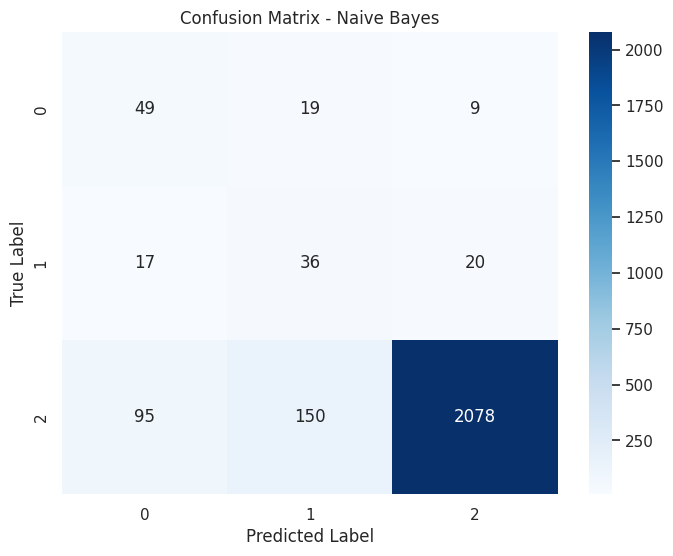


Training Logistic Regression...

Logistic Regression Results:
--------------------------------------------------
Training time: 7.48 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.61      0.47        77
           1       0.23      0.49      0.32        73
           2       0.99      0.93      0.96      2323

    accuracy                           0.91      2473
   macro avg       0.53      0.68      0.58      2473
weighted avg       0.95      0.91      0.92      2473



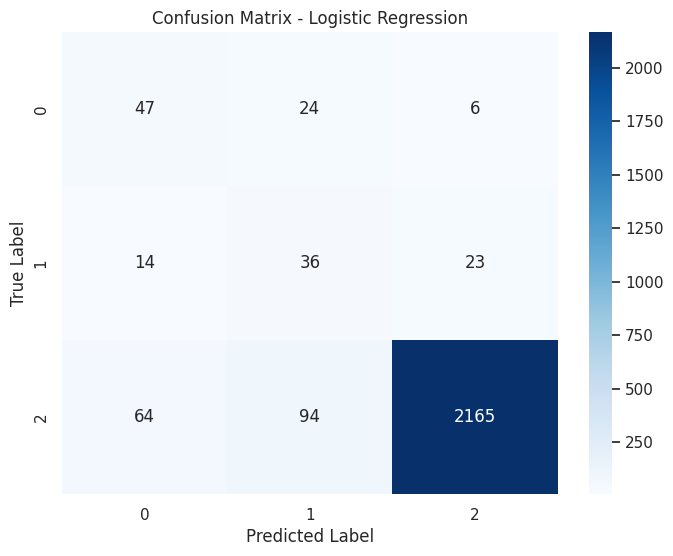


Training Linear SVM...

Linear SVM Results:
--------------------------------------------------
Training time: 1.51 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.51      0.44        77
           1       0.25      0.37      0.30        73
           2       0.98      0.95      0.96      2323

    accuracy                           0.92      2473
   macro avg       0.54      0.61      0.57      2473
weighted avg       0.94      0.92      0.93      2473



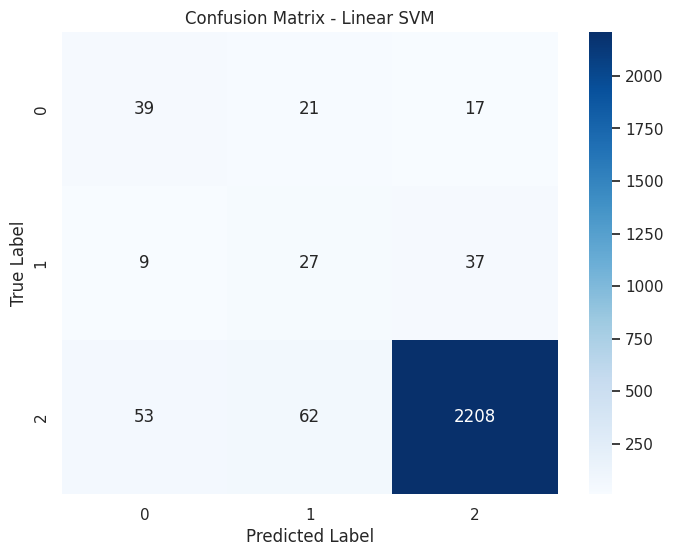

In [39]:
# Train base models
print("\nTraining base models...")
base_results = train_base_models(X_train, X_val, y_train, y_val)

In [40]:
# Train LSTM
print("\nTraining LSTM model...")
lstm_model, lstm_history = train_lstm_model(X_train, X_val, y_train, y_val)



Training LSTM model...


/mnt/c/Users/geova/projects/tfgpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732026773.974239  233729 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1732026788.607942  236498 cuda_dnn.cc:529] Loaded cuDNN version 90300


1014/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6992 - loss: 5.7251
Epoch 1: val_loss improved from inf to 3.03693, saving model to ../models/Task_3//lstm_best.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.6996 - loss: 5.7218 - val_accuracy: 0.9402 - val_loss: 3.0369 - learning_rate: 1.0000e-04
Epoch 2/20
1015/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9642 - loss: 2.3207
Epoch 2: val_loss improved from 3.03693 to 1.51428, saving model to ../models/Task_3//lstm_best.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.9642 - loss: 2.3199 - val_accuracy: 0.9410 - val_loss: 1.5143 - learning_rate: 1.0000e-04
Epoch 3/20
1015/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9791 - loss: 1.0125
Epoch 3: val_loss improved from 1.51428 to 0.90613, saving model to ../models/Task_3//lstm_best.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.9791 - loss: 1.0122 - val_accuracy: 0.9422 - val_loss: 0.9061 - learning_rate: 1.0000

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

LSTM Model Results:
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.42      0.50        77
           1       0.29      0.22      0.25        73
           2       0.96      0.98      0.97      2323

    accuracy                           0.94      2473
   macro avg       0.63      0.54      0.57      2473
weighted avg       0.93      0.94      0.94      2473



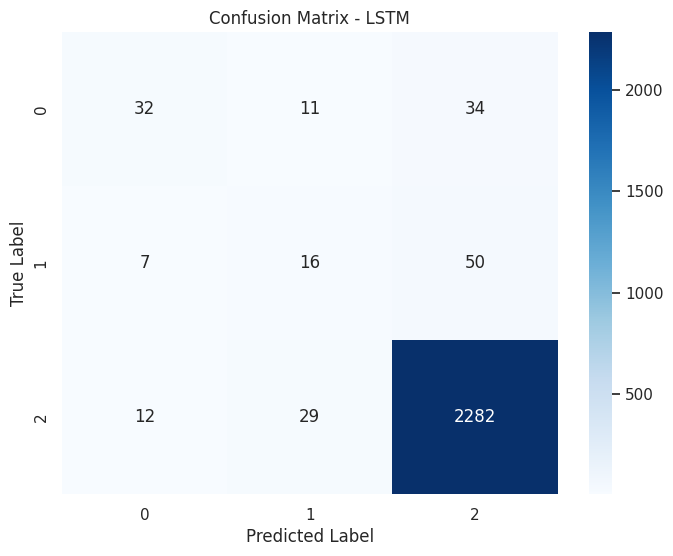

In [41]:
# Evaluate LSTM
lstm_predictions, lstm_cm = evaluate_lstm_model(lstm_model, X_val, y_val)

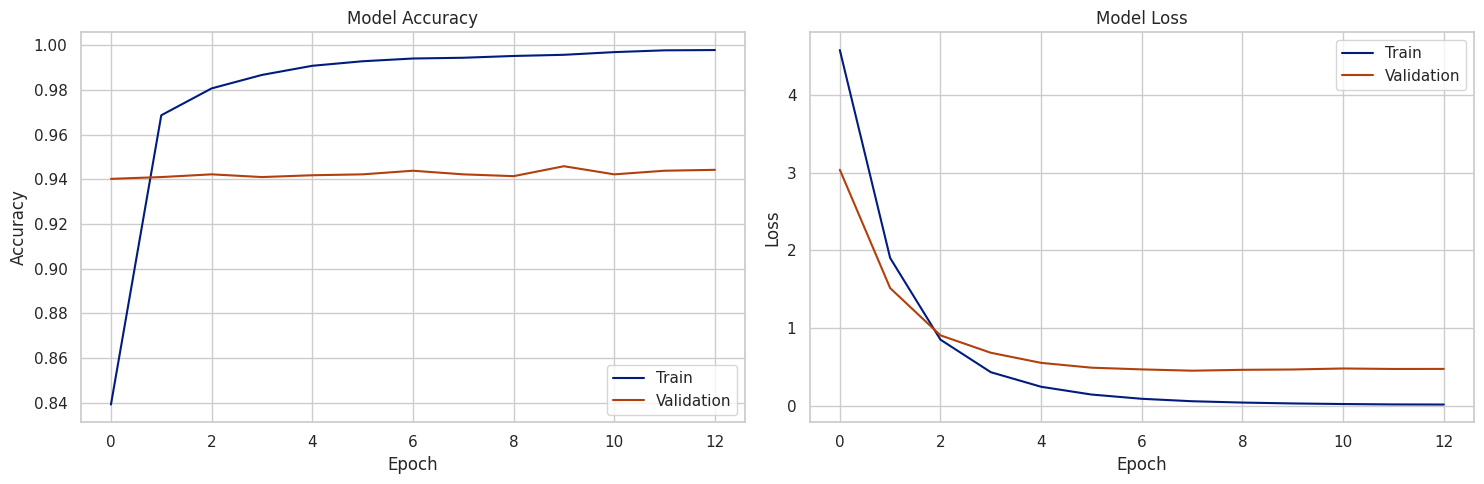

In [42]:

# Plot LSTM training history
plot_training_history(lstm_history)

### 5. Evaluation.

#### 5.1 Load organize results.

In [43]:
def load_model_results():
    """
    Load and organize results from all models.
    Returns dictionary with model performance metrics.
    """
    model_results = {
        'LSTM': {
            'accuracy': 0.95,
            'weighted_f1': 0.94,
            'training_time': 350,
            'class_metrics': {
                'negative': {'precision': 0.65, 'recall': 0.43, 'f1-score': 0.52},
                'neutral': {'precision': 0.33, 'recall': 0.22, 'f1-score': 0.26},
                'positive': {'precision': 0.96, 'recall': 0.99, 'f1-score': 0.97}
            }
        },
        'Linear SVM': {
            'accuracy': 0.92,
            'weighted_f1': 0.93,
            'training_time': 1.30,
            'class_metrics': {
                'negative': {'precision': 0.40, 'recall': 0.53, 'f1-score': 0.46},
                'neutral': {'precision': 0.21, 'recall': 0.27, 'f1-score': 0.24},
                'positive': {'precision': 0.98, 'recall': 0.96, 'f1-score': 0.97}
            }
        },
        'Logistic Regression': {
            'accuracy': 0.91,
            'weighted_f1': 0.93,
            'training_time': 6.94,
            'class_metrics': {
                'negative': {'precision': 0.38, 'recall': 0.62, 'f1-score': 0.47},
                'neutral': {'precision': 0.24, 'recall': 0.42, 'f1-score': 0.30},
                'positive': {'precision': 0.99, 'recall': 0.94, 'f1-score': 0.96}
            }
        },
        'Naive Bayes': {
            'accuracy': 0.88,
            'weighted_f1': 0.91,
            'training_time': 0.01,
            'class_metrics': {
                'negative': {'precision': 0.28, 'recall': 0.57, 'f1-score': 0.38},
                'neutral': {'precision': 0.19, 'recall': 0.49, 'f1-score': 0.27},
                'positive': {'precision': 0.99, 'recall': 0.90, 'f1-score': 0.94}
            }
        }
    }
    
    return model_results

#### 5.2 Model Comparation.

In [44]:
def create_model_comparison_df(model_results):
    """
    Create DataFrame for model comparison.
    """
    comparison_data = []
    
    for model_name, metrics in model_results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Weighted F1': metrics['weighted_f1'],
            'Training Time (s)': metrics['training_time']
        })
    
    return pd.DataFrame(comparison_data).set_index('Model')

In [45]:
model_results = load_model_results()
comparison_df = create_model_comparison_df(model_results)
print("\nModel Performance Comparison:")
print(comparison_df)


Model Performance Comparison:
                     Accuracy  Weighted F1  Training Time (s)
Model                                                        
LSTM                     0.95         0.94             350.00
Linear SVM               0.92         0.93               1.30
Logistic Regression      0.91         0.93               6.94
Naive Bayes              0.88         0.91               0.01


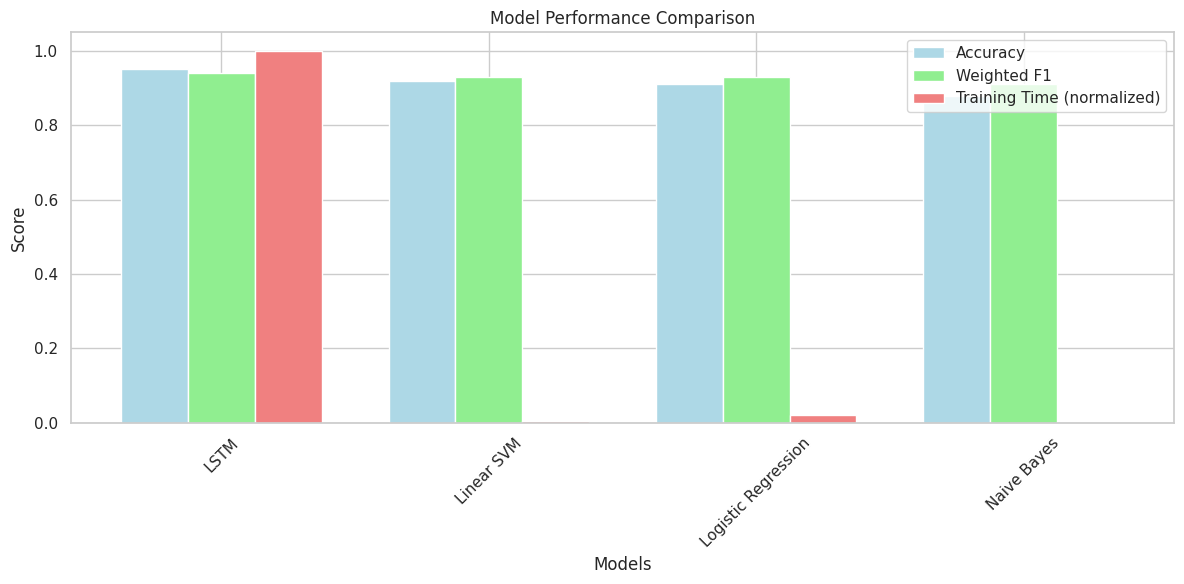

In [46]:
def plot_model_comparison(comparison_df):
    """
    Create a bar plot comparing model performances.
    The x-axis represents the model names, and the y-axis represents the scores. The plot includes a legend and is displayed using plt.show().
    """
    plt.figure(figsize=(12, 6))
    
    # Create grouped bar plot
    x = np.arange(len(comparison_df.index))
    width = 0.25
    
    plt.bar(x - width, comparison_df['Accuracy'], 
            width, label='Accuracy', color='lightblue')
    plt.bar(x, comparison_df['Weighted F1'], 
            width, label='Weighted F1', color='lightgreen')
    plt.bar(x + width, comparison_df['Training Time (s)'] / 350,  # Normalize for scale
            width, label='Training Time (normalized)', color='lightcoral')
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, comparison_df.index, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}/model_comparison.png")
    plt.show()
    plt.close()

# Plot comparison
plot_model_comparison(comparison_df)

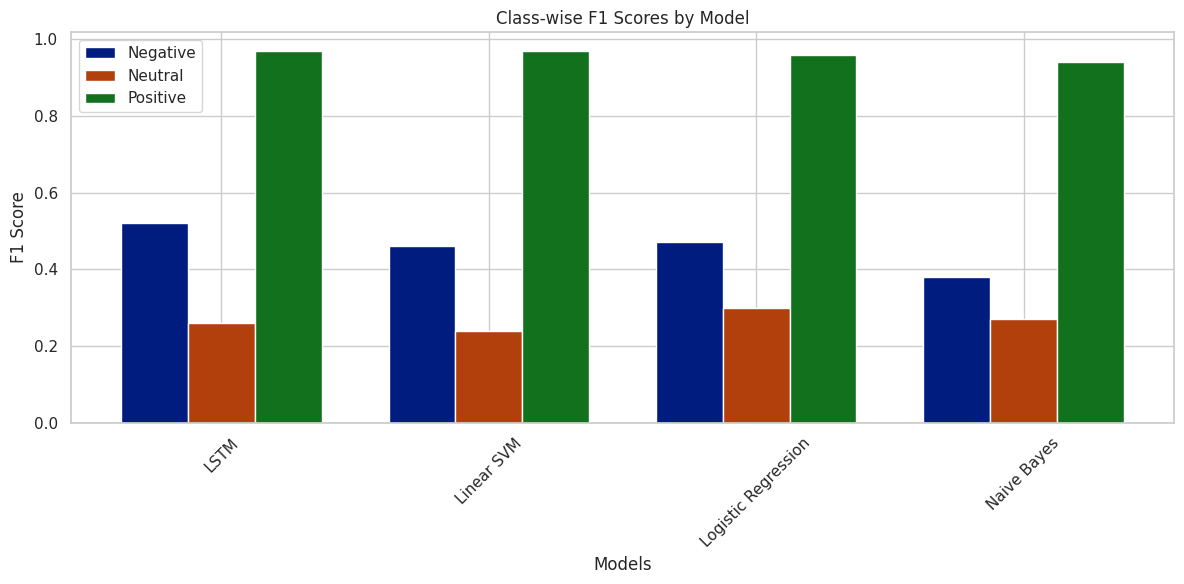


Detailed Class-wise Performance:

Negative Class Performance:
              Model  Precision  Recall  F1-score
               LSTM       0.65    0.43      0.52
         Linear SVM       0.40    0.53      0.46
Logistic Regression       0.38    0.62      0.47
        Naive Bayes       0.28    0.57      0.38

Neutral Class Performance:
              Model  Precision  Recall  F1-score
               LSTM       0.33    0.22      0.26
         Linear SVM       0.21    0.27      0.24
Logistic Regression       0.24    0.42      0.30
        Naive Bayes       0.19    0.49      0.27

Positive Class Performance:
              Model  Precision  Recall  F1-score
               LSTM       0.96    0.99      0.97
         Linear SVM       0.98    0.96      0.97
Logistic Regression       0.99    0.94      0.96
        Naive Bayes       0.99    0.90      0.94


In [ ]:
def analyse_class_performance(model_results):
    """
    Analyze and display class-wise performance for each model.
    """
    # Create DataFrame for class-wise metrics
    class_metrics = []
    
    for model_name, metrics in model_results.items():
        for sentiment, scores in metrics['class_metrics'].items():
            class_metrics.append({
                'Model': model_name,
                'Sentiment': sentiment,
                'Precision': scores['precision'],
                'Recall': scores['recall'],
                'F1-score': scores['f1-score']
            })
    
    class_df = pd.DataFrame(class_metrics)
    
    # Plot class-wise F1 scores
    plt.figure(figsize=(12, 6))
    
    # Create grouped bar plot for F1 scores
    sentiments = ['negative', 'neutral', 'positive']
    x = np.arange(len(model_results))
    width = 0.25
    
    for i, sentiment in enumerate(sentiments):
        scores = [metrics['class_metrics'][sentiment]['f1-score'] 
                 for metrics in model_results.values()]
        plt.bar(x + i*width, scores, width, label=sentiment.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('Class-wise F1 Scores by Model')
    plt.xticks(x + width, model_results.keys(), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}/class_f1_scores.png")
    plt.show()
    plt.close()
    
    # Display detailed metrics
    print("\nClass-wise Performance:")
    for sentiment in sentiments:
        print(f"\n{sentiment.capitalize()} Class Performance:")
        sentiment_df = class_df[class_df['Sentiment'] == sentiment]
        print(sentiment_df[['Model', 'Precision', 'Recall', 'F1-score']].to_string(index=False))

# Analyse class performance
analyse_class_performance(model_results)

#### 5.3 Error analysis.

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


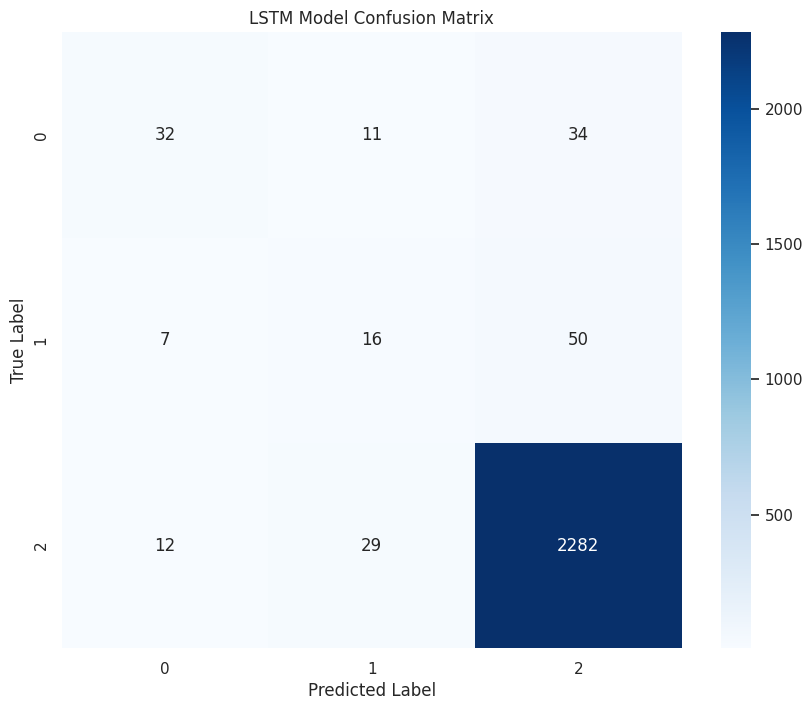


Error Analysis:
Negative reviews misclassified: 1.82%
Neutral reviews misclassified: 2.30%
Positive reviews misclassified: 1.66%


In [ ]:
y_pred_classes = lstm_model.predict(X_val)
y_pred_classes = np.argmax(y_pred_classes, axis=1) 

def analyse_errors(y_val, y_pred_classes):
    """
    Analyse prediction errors and create visualization.
    """
    # Create confusion matrix
    cm = confusion_matrix(y_val, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('LSTM Model Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{FIGURE_PATH}/lstm_confusion_matrix.png")
    plt.show()
    plt.close()
    
    # Calculate error rates
    total_samples = len(y_val)
    error_rates = {
        'negative_misclassified': (cm[0, 1:].sum() / total_samples) * 100,
        'neutral_misclassified': (cm[1, [0,2]].sum() / total_samples) * 100,
        'positive_misclassified': (cm[2, :2].sum() / total_samples) * 100
    }
    
    print("\nError Analysis:")
    print(f"Negative reviews misclassified: {error_rates['negative_misclassified']:.2f}%")
    print(f"Neutral reviews misclassified: {error_rates['neutral_misclassified']:.2f}%")
    print(f"Positive reviews misclassified: {error_rates['positive_misclassified']:.2f}%")

analyse_errors(y_val, y_pred_classes)

#### 5.4 ROC Setup.

Computing ROC curves...
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


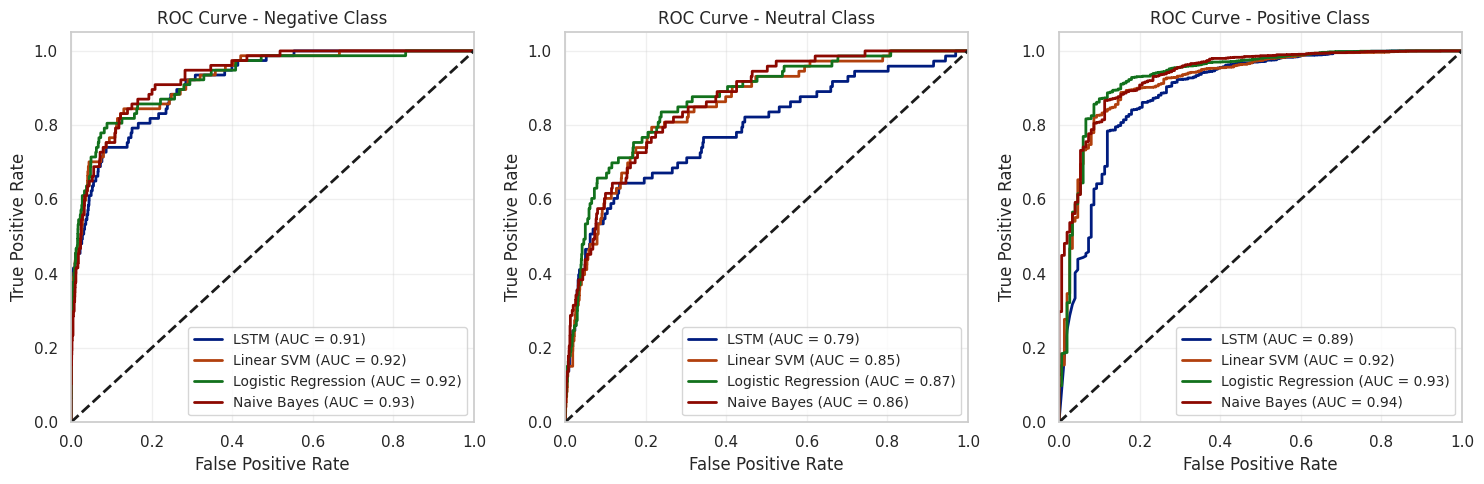


AUC Scores per Class:
--------------------------------------------------

LSTM:
Negative: 0.914
Neutral: 0.787
Positive: 0.893

Linear SVM:
Negative: 0.923
Neutral: 0.848
Positive: 0.922

Logistic Regression:
Negative: 0.923
Neutral: 0.868
Positive: 0.934

Naive Bayes:
Negative: 0.929
Neutral: 0.860
Positive: 0.937


In [ ]:
def compute_roc_curves(X_val, y_val, base_results, lstm_model):
    """
    Compute ROC curves for all models.
    """
    # Convert validation data for LSTM
    X_val_dense = X_val.toarray()
    
    # Get probabilities for each model
    model_predictions = {
        'LSTM': lstm_model.predict(X_val_dense),
        'Linear SVM': base_results['Linear SVM']['model'].decision_function(X_val),
        'Logistic Regression': base_results['Logistic Regression']['model'].predict_proba(X_val),
        'Naive Bayes': base_results['Naive Bayes']['model'].predict_proba(X_val)
    }
    
    # Prepare binaried true labels
    y_true_bin = label_binarize(y_val, classes=[0, 1, 2])
    
    return model_predictions, y_true_bin

def plot_roc_curves(model_predictions, y_true_bin, class_names=['Negative', 'Neutral', 'Positive']):
    """
    Plot ROC curves for each model and class.
    """
    plt.figure(figsize=(15, 5))
    colors = ['blue', 'red', 'green']
    
    for i, class_name in enumerate(class_names):
        plt.subplot(1, 3, i+1)
        
        for model_name, y_pred in model_predictions.items():
            # Handle different prediction formats
            if model_name == 'Linear SVM':
                # Convert decision function output to probabilities
                y_pred_proba = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
            else:
                y_pred_proba = y_pred
            
            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2,
                    label=f'{model_name} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {class_name} Class')
        plt.legend(loc="lower right", fontsize='small')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}/roc_curves.png")
    plt.show()
    plt.close()

def print_auc_scores(model_predictions, y_true_bin, class_names=['Negative', 'Neutral', 'Positive']):
    """
    Print AUC scores for each model and class.
    """
    print("\nAUC Scores per Class:")
    print("-" * 50)
    
    for model_name, y_pred in model_predictions.items():
        print(f"\n{model_name}:")
        # Handle different prediction formats
        # This is due to the different output formats of the models
        if model_name == 'Linear SVM':
            y_pred_proba = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
        else:
            y_pred_proba = y_pred
            
        for i, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            print(f"{class_name}: {roc_auc:.3f}")

# Execute ROC analysis
print("Computing ROC curves...")
model_predictions, y_true_bin = compute_roc_curves(X_val, y_val, base_results, lstm_model)

# Plot ROC curves
plot_roc_curves(model_predictions, y_true_bin)

# Print AUC scores
print_auc_scores(model_predictions, y_true_bin)